In [6]:
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
from pathlib import Path
import tqdm
import glob
import numpy as np
import hvplot.xarray
import datetime as dt
import pandas as pd
import pyproj
from IPython.display import Video

#We will also use 'xmovie', but import that later otherwise it messes with plotting
#import xmovie

In [2]:
#Start up a dask client
client = Client()

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39523 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39523/status,
Dashboard: /proxy/39523/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35957,Workers: 4
Dashboard: /proxy/39523/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:43561,Total threads: 1
Dashboard: /proxy/44053/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:33551,


# 1) Using ImageMagick

To visualise ERA5 reanalysis data

### Load ERA5 data

Has been copied from the `rt52` project to the `gb02` project

In [4]:
#########################
#Surface air temperature#
#########################

#To load directly from rt52 (if you are a member and have added the gdata/rt52 storage flag to your ARE session)
#era5_tas = xr.open_dataset("/g/data/rt52/era5/single-levels/reanalysis/2t/2016/2t_era5_oper_sfc_20160901-20160930.nc",chunks={})

#To load from gb02 (where some sample data has been copied)
era5_tas = xr.open_dataset("/g/data/gb02/ab4502/animation_demo/data/era5_201609/2t_era5_oper_sfc_20160901-20160930.nc",chunks={})

#########################
#        MSLP           #
#########################
#To load directly from rt52 (if you are a member and have added the gdata/rt52 storage flag to your ARE session)
#era5_msl = xr.open_dataset("/g/data/rt52/era5/single-levels/reanalysis/msl/2016/msl_era5_oper_sfc_20160901-20160930.nc",chunks={}) / 100

#To load from gb02 (where some sample data has been copied)
era5_msl = xr.open_dataset("/g/data/gb02/ab4502/animation_demo/data/era5_201609/msl_era5_oper_sfc_20160901-20160930.nc",chunks={}) / 100

#Combine into a single dataset for convenience
era5_ds = xr.Dataset({"tas":era5_tas["t2m"],"msl":era5_msl["msl"]})

#Slice it down to time and domain of interest
era5_ds = era5_ds.sel(time=slice("2016-09-27 00:00","2016-09-28 23:00"),latitude=slice(0,0-50),longitude=slice(105,160))

### Define our plotting function

Say we want to plot the evolution of temperature and MSLP through time. Define the plot for a single time step

Test it out by plotting the first time step

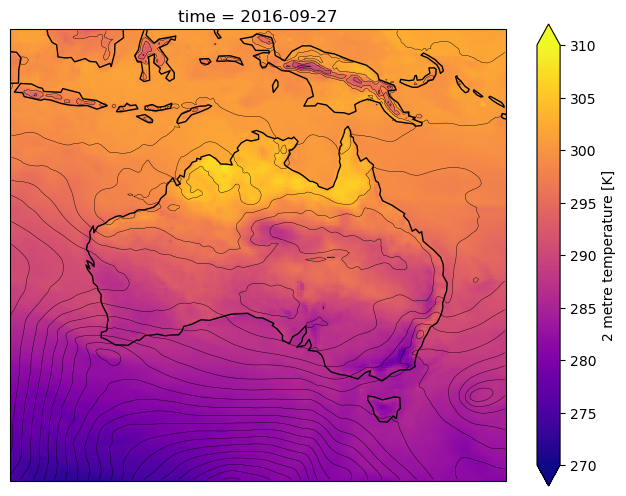

In [5]:
def plot_tas_mslp(ax,ds):
    '''
    ax: pyplot axes to plot on
    ds: Xarray dataset with lat lon dims (single time step)
    '''

    #Define pressure levels for plotting mslp
    p_levels = np.arange(980,1028,2)

    #Plot air temp. We want to manually define the colorbar extent (vmin, vmax, extend) so that it doesn't change through
    # the animation
    ds.tas.plot(ax=ax,vmin=270,vmax=310,extend="both",cmap="plasma")

    #Plot mslp
    ds.msl.plot.contour(ax=ax,levels=p_levels,colors=["k"],linewidths=0.3)

#Open a new figure
fig = plt.figure(figsize=[8,6])

#Create new pyplot axis. Setting a cartopy projection makes it a "geoaxes", which has knows about coastlines
ax=plt.axes(projection=ccrs.PlateCarree())

#Run the plotting function for a single timestep
plot_tas_mslp(ax, era5_ds.isel(time=0))

#Draw the coastline
ax.coastlines()

Now we can loop over all the time steps, and save plots to disk

This could probably be done with [matplotlib](https://matplotlib.org/stable/api/animation_api.html) but I found it more complicated

In [7]:
#Set up paths to save figures 

#Define output path 
SCRATCH_DIR = Path('/scratch')
DUMP_DIR = SCRATCH_DIR / os.environ["PROJECT"] / os.environ["USER"] / 'temp_figs'

#Create the directory if it doesn't already exist
if os.path.isdir(DUMP_DIR):
    #Remove previous figures and animations
    [os.remove(f) for f in glob.glob(f'{DUMP_DIR}/*.png')]
    [os.remove(f) for f in glob.glob(f'{DUMP_DIR}/*.gif')]
    [os.remove(f) for f in glob.glob(f'{DUMP_DIR}/*.mp4')]
else:
    os.mkdir(DUMP_DIR)



In [8]:
#Loop over time steps in the dataset
for t in tqdm.tqdm(np.arange(era5_ds.time.shape[0])):

    #As before, but for time, t
    fig = plt.figure(figsize=[8,6])
    ax=plt.axes(projection=ccrs.PlateCarree())
    plot_tas_mslp(ax, era5_ds.isel(time=t))
    ax.coastlines()

    #Save the plot to disk in time order
    plt.savefig(f'{DUMP_DIR}/{str(t).zfill(3)}.png')

    #Don't forget to close the figure or else we will open a lot of them
    plt.close(fig)

100%|██████████| 48/48 [00:30<00:00,  1.59it/s]


In [8]:
print(DUMP_DIR)

/scratch/ng72/ab4502/temp_figs/


In [9]:
#Use imagemagick to combine png files into an animation

#Can run the below in a terminal, or by using "!" in a notebook
#Will create ram3_animation.gif in the same directory as the temp .png figs by default
#Delay controls the speed of the animation
#Loop controls how many loop iterations

cmd = f'convert -delay 20 -loop 20 {DUMP_DIR}/*.png {DUMP_DIR}/era5_animation.gif'
!$cmd